### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'BR_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest', 'SVM_poly','XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
# Bayesian Ridge Imputation ---> Train set
imputed_data = train.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(imputed_data)
imputed_data = pd.DataFrame(imputer.transform(imputed_data), columns = imputed_data.columns, index=imputed_data.index )
imputed_data = pd.concat([train[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)
train = imputed_data.copy()
train.isna().sum().sum()

0

In [8]:
# Bayesian Ridge Imputation ---> Test set

imputed_data = test.copy()
diag_dummies = pd.get_dummies(imputed_data['diagnosis'])
imputed_data = pd.concat([imputed_data, diag_dummies], axis=1)
imputed_data = imputed_data.drop(['site', 'id', 'diagnosis', 'strata'], axis=1)
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=1000))
imputer = imputer.fit(imputed_data)
imputed_data = pd.DataFrame(imputer.transform(imputed_data), columns = imputed_data.columns, index=imputed_data.index )
imputed_data = pd.concat([test[['site', 'id', 'diagnosis', 'strata']], imputed_data], axis=1)
test = imputed_data.copy()
test.isna().sum().sum()

0

In [9]:
train.shape, test.shape

((1450, 48), (161, 48))

In [10]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
              'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs',
              'functionality', 'marital_status', 'n_children', 'household_members', 'household_income',
              'Job_status', 'strata']

train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [11]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'moca_vs', 'ace_vs', 'functionality', 'marital_status',
       'n_children', 'household_members', 'household_income', 'Job_status',
       'strata'],
      dtype='object')

In [12]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 17), (161, 17))

In [13]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [14]:
### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-25/BR_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "BR_RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "BR_SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "BR_xgb_hparams.csv", usecols=['param_learning_rate',
       'param_max_depth', 'param_n_estimators', 'param_colsample_bytree','param_min_child_weight',
        'params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [15]:
rf_row = 0
rf_hp.iloc[0,:]

param_criterion                                                      entropy
param_max_depth                                                            9
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       402
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                       0.8589
mean_train_score                                                    0.981169
Name: 0, dtype: object

In [16]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                       9.67159
param_coef0                                                        28
param_degree                                                        2
param_gamma                                                  2.269344
params              OrderedDict([('C', 9.671589615563061), ('coef0...
mean_test_score                                               0.82717
mean_train_score                                              0.93468
Name: 0, dtype: object

In [17]:
xgb_row=0
xgb_hp.iloc[0, :]

param_colsample_bytree                                                  0.6
param_learning_rate                                                 0.10057
param_max_depth                                                           3
param_min_child_weight                                                   15
param_n_estimators                                                      124
params                    OrderedDict([('colsample_bytree', 0.6), ('eval...
mean_test_score                                                    0.883925
mean_train_score                                                   0.958401
Name: 0, dtype: object

In [44]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0, 'max_iter':10**6}

#XGBOOST
xgb_params = {
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'colsample_bytree': xgb_hp.loc[xgb_row, 'param_colsample_bytree'],
    'min_child_weight': xgb_hp.loc[xgb_row, 'param_min_child_weight'],
    'gamma': 1,
    'subsample':1.0,
#     'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}


In [19]:
n_iter =5000

### Base model: Logistic Regression

In [20]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:19<00:00, 25.09it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.322581140200297 minutes
empirical p-value: 0.0


In [21]:
lr_res.mean()

Accuracy         0.804673
ROC_AUC          0.815593
Precision        0.766273
Recall           0.251330
Sensitivity      0.251330
Specificity      0.975503
F1               0.374860
Efron_pR2        0.235255
mcfadden_pR2     0.609597
mcfadden_apR2    0.549996
dtype: float64

In [22]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.010989,0.01075,0.011731,0.012024,0.012024,0.004285,0.013418,0.011757,0.013522,0.01379


In [23]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,-0.172445,0.198038,-0.569592,0.658990,0.999767,2.220446e-16
1,ace_vs,1.519492,0.165439,2.412914,0.318532,0.039629,1.003270e-02
2,functionality,-0.818755,0.193607,-3.246081,0.812612,0.012110,2.963684e-02
3,household_income,-1.205133,0.186007,-3.851123,0.730981,0.001613,4.107496e-03
4,household_members,0.068432,0.121572,0.042267,0.075806,0.999989,1.110223e-16


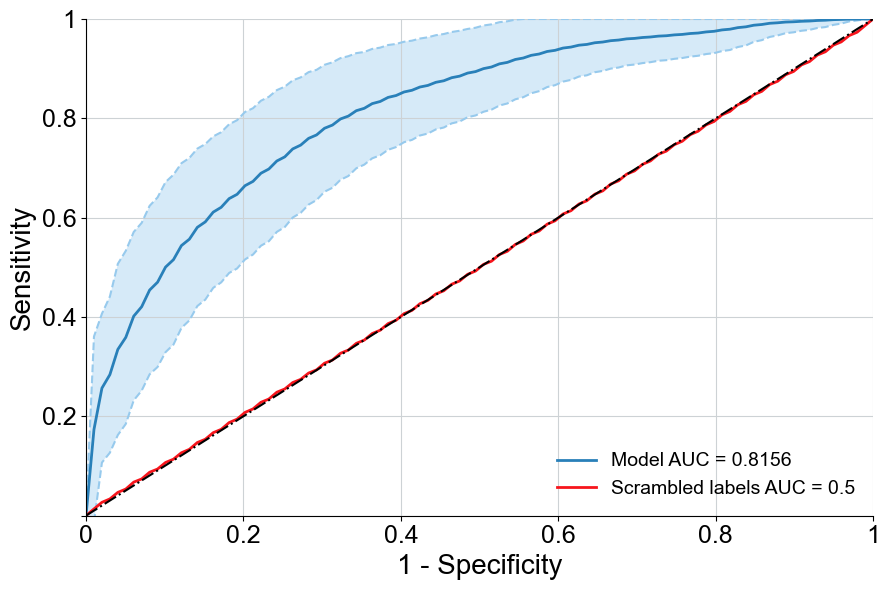

In [24]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [25]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
rf_fimp.sort_values('mean', ascending=False)#.to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

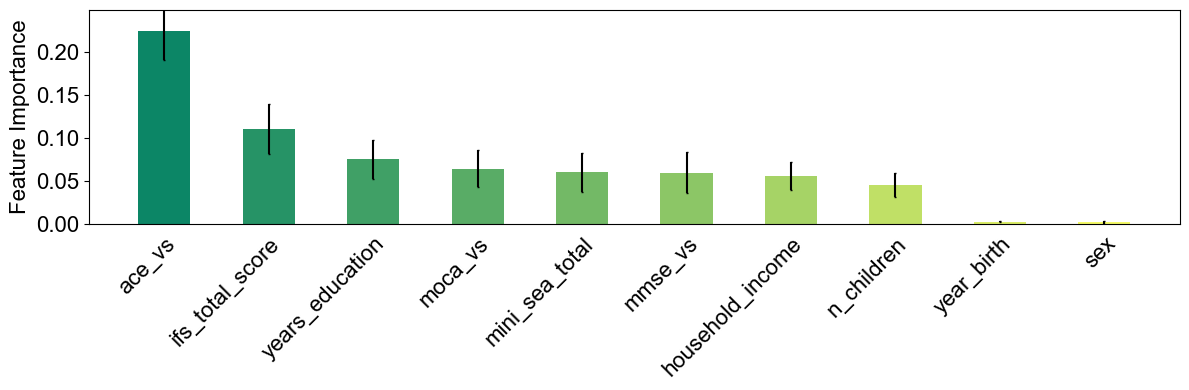

In [27]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

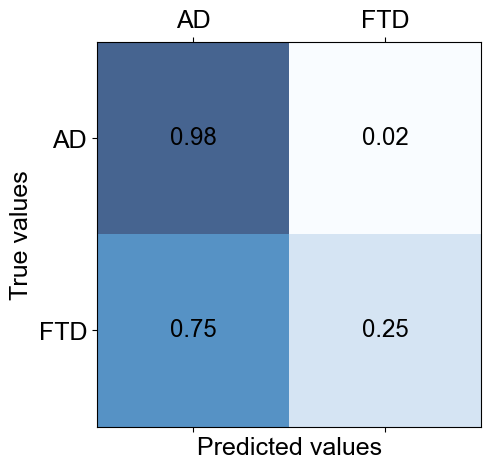

In [28]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [29]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [30]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [31]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [32]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']

In [33]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5495
Accuracy: 0.757
Recall: 0.16
F1: 0.2353
Precision:0.4444


In [34]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5495
Bootstrping test ROC score: 	0.8156


### RF Model

##### Bootstrap

In [35]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=402, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:05:32<00:00,  1.27it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:65.54206240971884 minutes
empirical p-value: 0.0


In [36]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-11-25/BR_res'

In [37]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.825951
ROC_AUC        0.870044
Precision      0.626522
Recall         0.662078
Sensitivity    0.662078
Specificity    0.876542
F1             0.641731
Efron_pR2      0.196110
dtype: float64

In [38]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8700


In [39]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.01051,0.009321,0.013408,0.013111,0.013111,0.009118,0.013291,0.011006


In [40]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
14,year_birth,0.123674,0.007623
7,mini_sea_total,0.093680,0.006008
4,household_members,0.072223,0.004625
1,ace_vs,0.065931,0.004287
15,years_education,0.064304,0.005090
6,marital_status,0.063835,0.004005
5,ifs_total_score,0.063687,0.003594
10,n_children,0.062587,0.004197
12,npi_total_caregiver,0.059321,0.003073
2,functionality,0.058765,0.003854


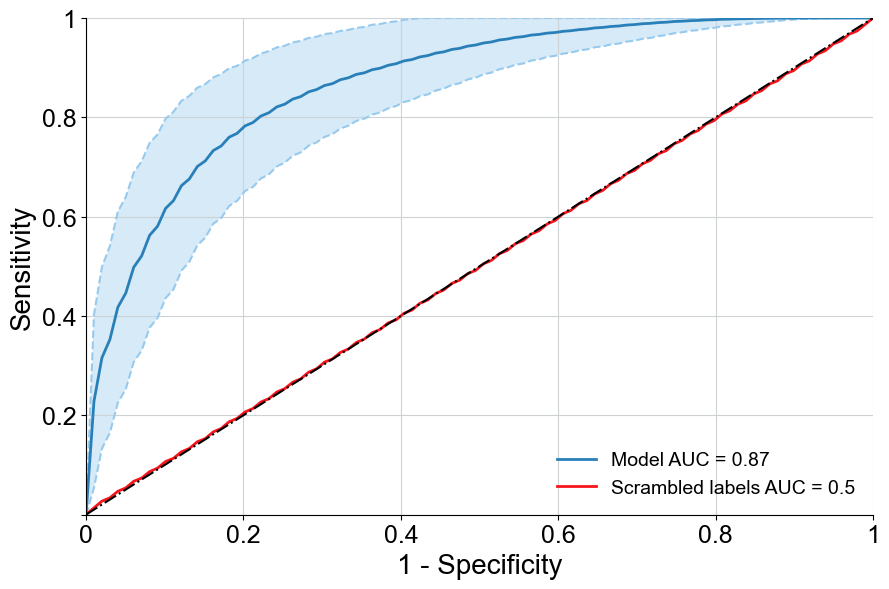

In [41]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


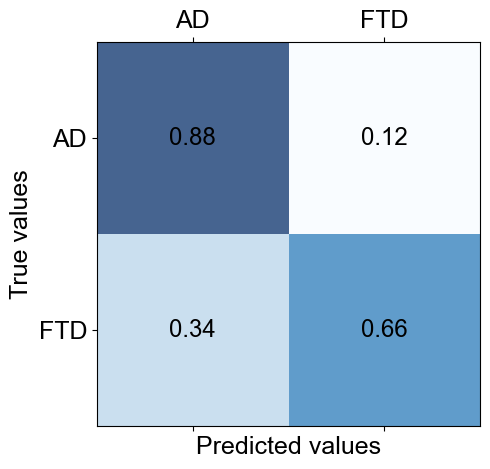

In [42]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [45]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [46]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [47]:
top_10p.head()

,predictor,mean,std
4,mini_sea_total,0.038734,0.010006
0,year_birth,0.038338,0.009663
2,years_education,0.017036,0.006423
3,ifs_total_score,0.012366,0.005223
13,household_members,0.012355,0.006618


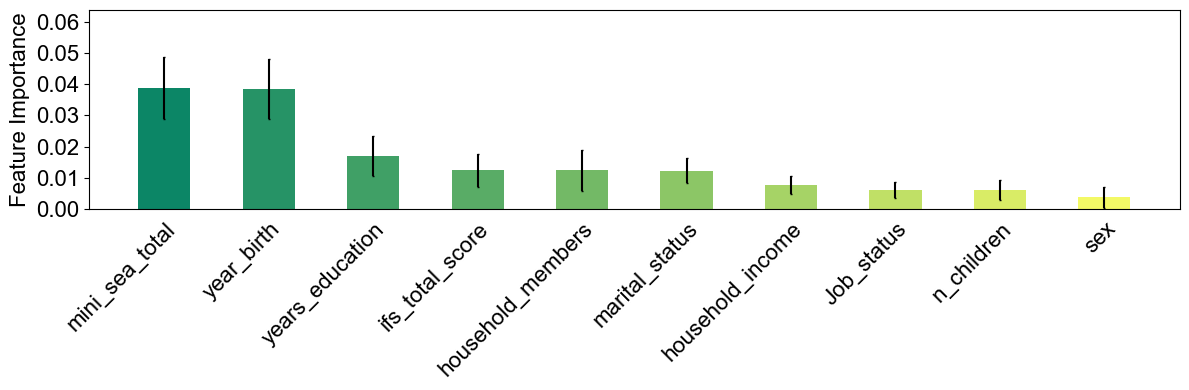

In [48]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [49]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
14,year_birth,0.123674,0.007623
7,mini_sea_total,0.093680,0.006008
4,household_members,0.072223,0.004625
1,ace_vs,0.065931,0.004287
15,years_education,0.064304,0.005090


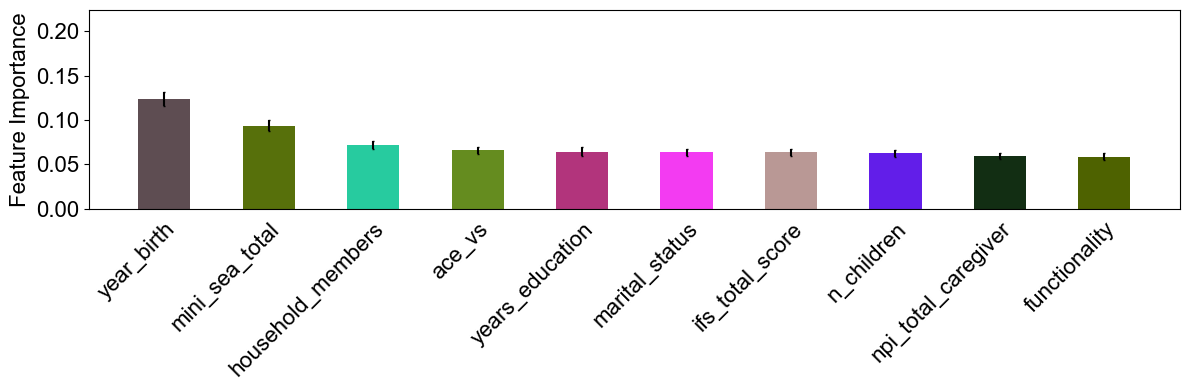

In [50]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [51]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [52]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [53]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.7373
Accuracy: 0.8318
Recall: 0.56
F1: 0.6087
Precision:0.6667


In [54]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.7373
Bootstrping test ROC score: 	0.8700


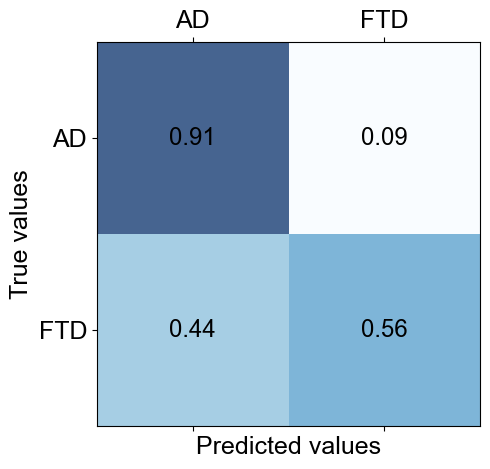

In [55]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM_unseen.png")

#### Shapley

In [56]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


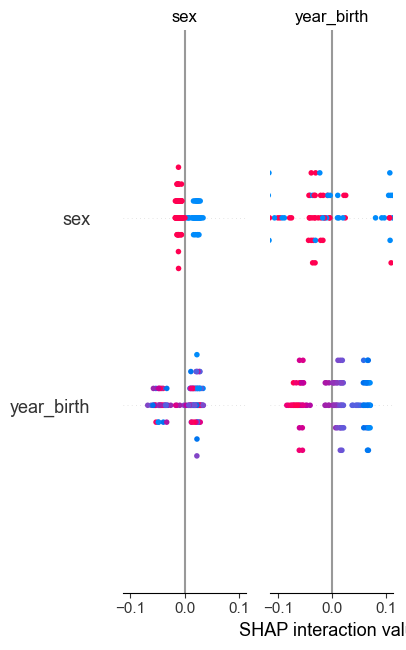

In [57]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

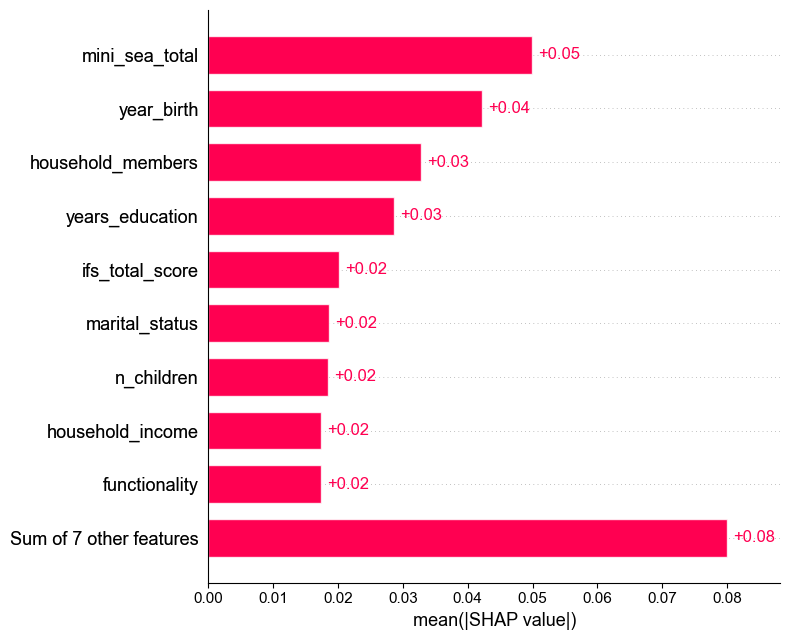

In [58]:
shap.plots.bar(shap_values[:,:,1])

### SVM - Poly

#### Bootstrap

In [59]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=9.67158961556306, class_weight='balanced', coef0=28, degree=2,
    gamma=2.269343998557728, kernel='poly', max_iter=1000000, verbose=0)


Iterating: 100%|██████████████████| 5000/5000 [44:16<00:00,  1.88it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:44.281999691327414 minutes
empirical p-value: 0.0


In [60]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.790567
ROC_AUC        0.766055
Precision      0.544547
Recall         0.719648
Sensitivity    0.719648
Specificity    0.812462
F1             0.618407
dtype: float64

In [61]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.011279
ROC_AUC_ci        0.011734
Precision_ci      0.013804
Recall_ci         0.012450
Sensitivity_ci    0.012450
Specificity_ci    0.010820
F1_ci             0.013465
dtype: float64

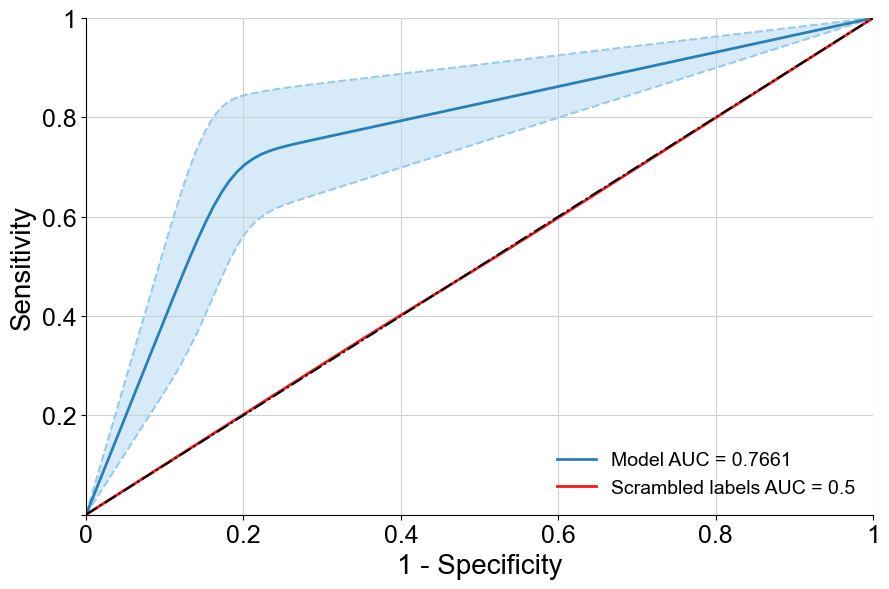

In [62]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

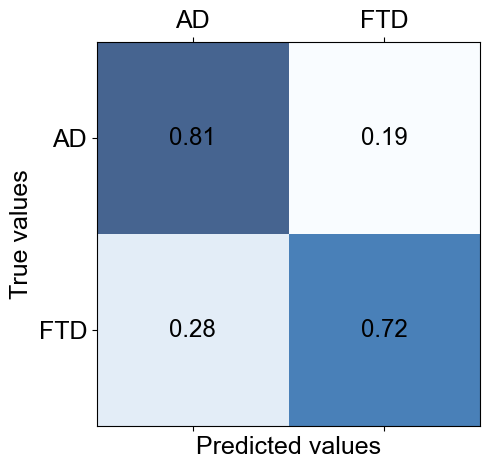

In [63]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [64]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=1000, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


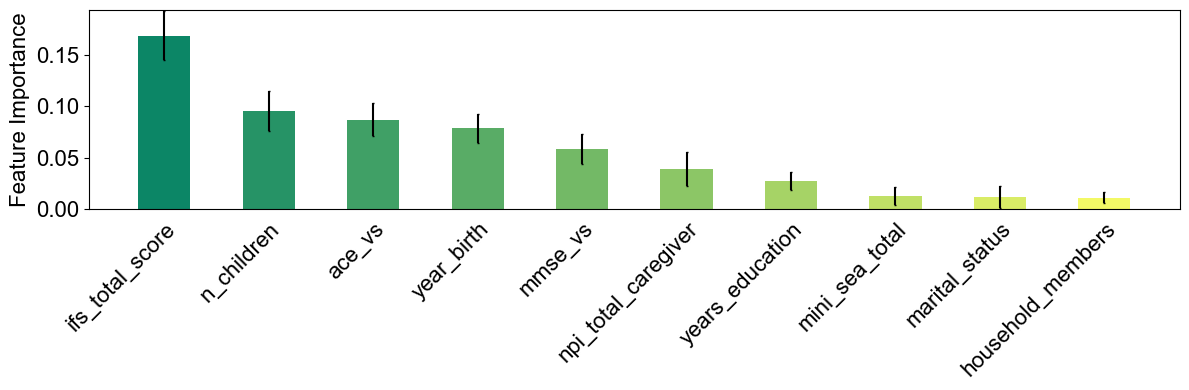

In [65]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [66]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [67]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [68]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6137
Accuracy: 0.6636
Recall: 0.52
F1: 0.4194
Precision:0.3514

Unseen Data ROC score: 		0.6137
Bootstrping test ROC score: 	0.7661


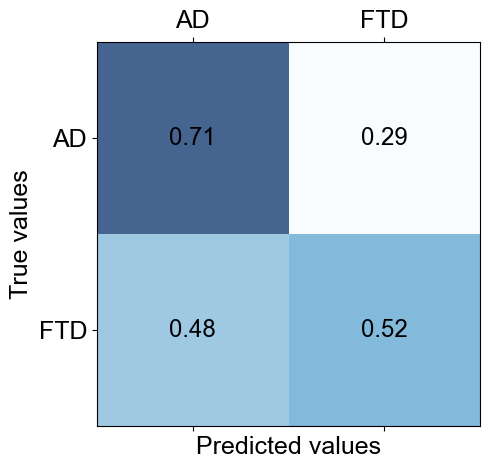

In [69]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_PFI_unseen.png")

#### Shapley

In [70]:
# poly_params['probability'] = True

In [71]:
# # compute SHAP values
# poly = SVC(**poly_params)
# poly=poly.fit(X_train, y_train)

# masker=shap.maskers.Independent(X_train, max_samples=1)
# # explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
# explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
# shap_values = explainer.shap_values(X_train, masker = masker)
# # explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

In [72]:
# shap.summary_plot(shap_values, feature_names=X_train.columns)
# # shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

#### Bootstrap

In [73]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 5000/5000 [10:19<00:00,  8.07it/s]


singular_matrix_errors (droped from results): 0
Eleapsed time:10.33252607981364 minutes
empirical p-value: 0.0


In [74]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.839243
ROC_AUC        0.867073
Precision      0.735734
Recall         0.503222
Sensitivity    0.503222
Specificity    0.942981
F1             0.594428
Efron_pR2      0.363845
dtype: float64

In [75]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
7,mini_sea_total,51.6242,4.417610,7.000722,0.486037
6,marital_status,37.6026,5.955549,5.527339,0.631165
15,years_education,32.2458,3.576303,5.247765,0.621196
14,year_birth,30.4950,3.286904,14.976369,1.272521
3,household_income,29.4534,4.137300,3.899132,0.446601
4,household_members,27.4222,4.630922,5.431697,0.687974
1,ace_vs,27.2204,4.217272,9.749773,1.219531
5,ifs_total_score,25.7562,4.448811,4.540004,0.526620
12,npi_total_caregiver,24.1078,5.038617,3.755859,0.578439
2,functionality,23.4894,5.590504,4.886878,0.957237


In [76]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010181,0.00941,0.012222,0.013859,0.013859,0.006427,0.01361,0.013336


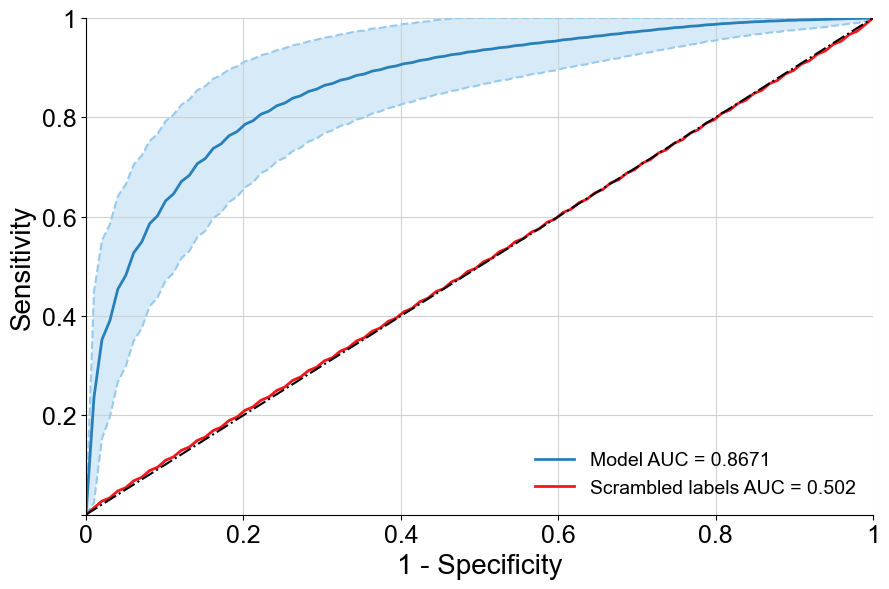

In [77]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

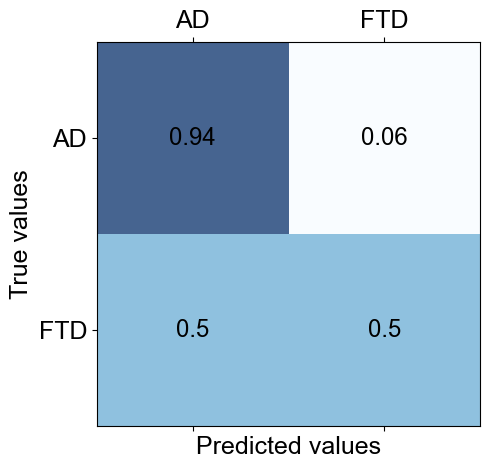

In [78]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [79]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

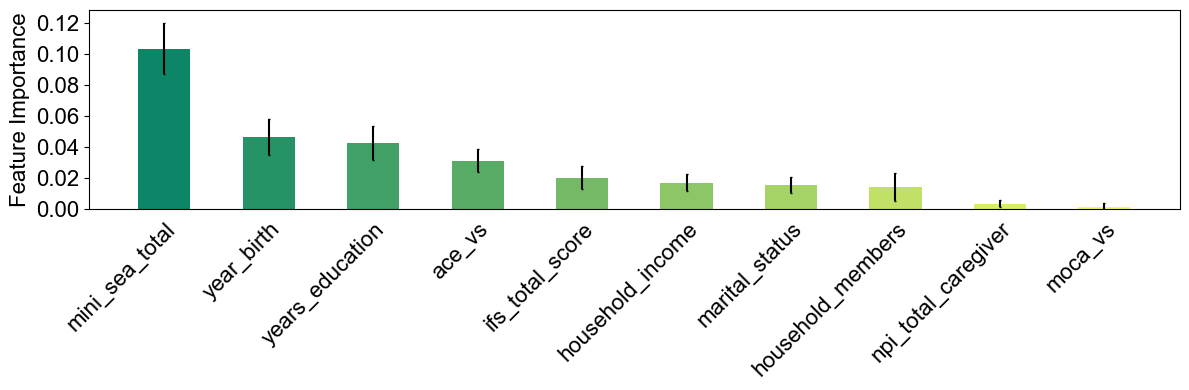

In [80]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [81]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,Job_status,14.694000,4.393976,3.700865,0.650854
1,ace_vs,27.220400,4.217272,9.749773,1.219531
2,functionality,23.489400,5.590504,4.886878,0.957237
3,household_income,29.453400,4.137300,3.899132,0.446601
4,household_members,27.422200,4.630922,5.431697,0.687974
5,ifs_total_score,25.756200,4.448811,4.540004,0.526620
6,marital_status,37.602600,5.955549,5.527339,0.631165
7,mini_sea_total,51.624200,4.417610,7.000722,0.486037
8,mmse_vs,13.137400,4.051790,6.265534,1.381223
9,moca_vs,8.692246,3.476958,3.411165,0.874296


In [82]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
7,mini_sea_total,51.6242,4.417610,7.000722,0.486037
6,marital_status,37.6026,5.955549,5.527339,0.631165
15,years_education,32.2458,3.576303,5.247765,0.621196
14,year_birth,30.4950,3.286904,14.976369,1.272521
3,household_income,29.4534,4.137300,3.899132,0.446601
4,household_members,27.4222,4.630922,5.431697,0.687974
1,ace_vs,27.2204,4.217272,9.749773,1.219531
5,ifs_total_score,25.7562,4.448811,4.540004,0.526620
12,npi_total_caregiver,24.1078,5.038617,3.755859,0.578439
2,functionality,23.4894,5.590504,4.886878,0.957237


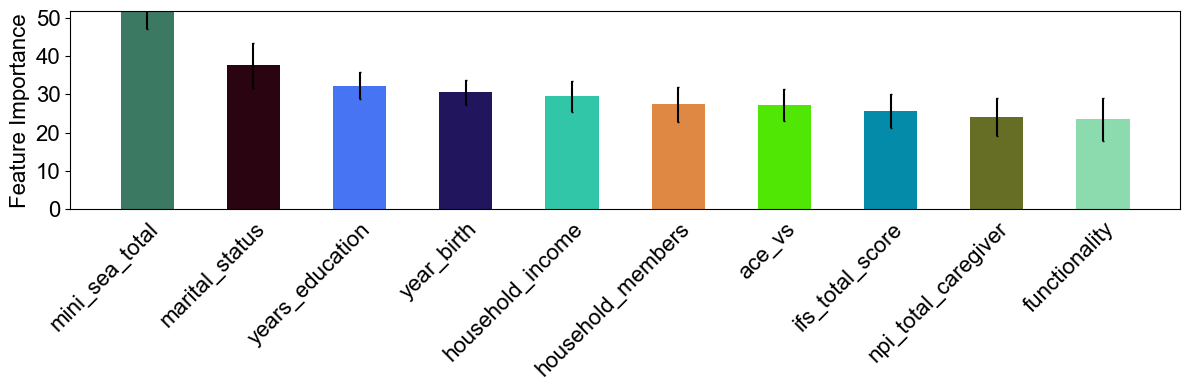

In [83]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

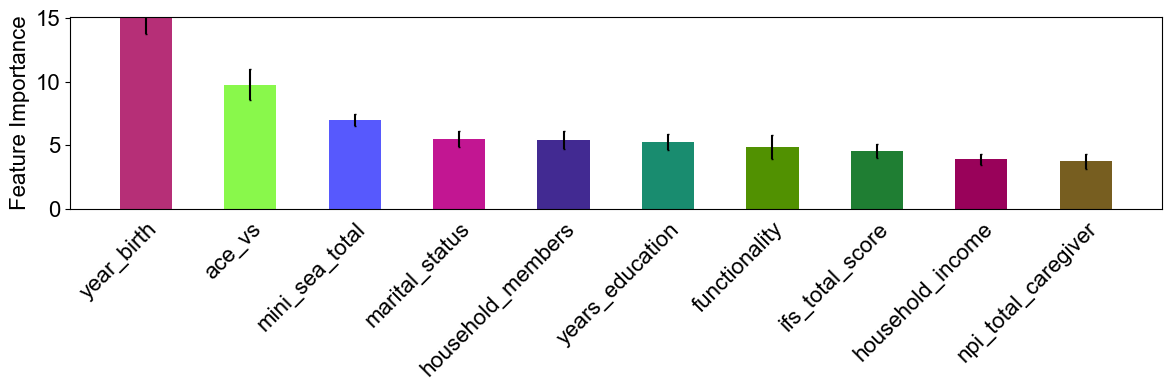

In [84]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [85]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [86]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [87]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6295
Accuracy: 0.7944
Recall: 0.32
F1: 0.4211
Precision:0.6154

Unseen Data ROC score: 		0.6295
Bootstrping test ROC score: 	0.8671


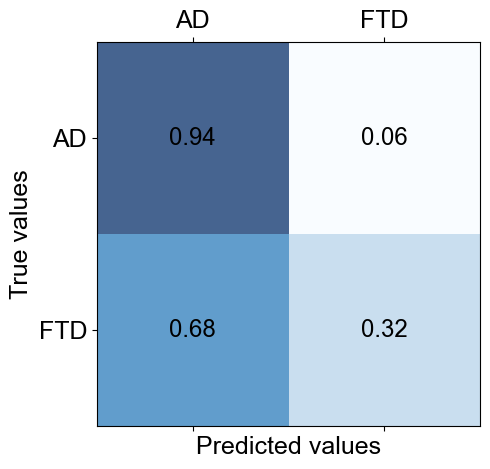

In [88]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM_unseen.png")

#### Shapley

In [89]:
# # compute SHAP values
# explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
# shap_values = explainer(X_train, check_additivity=False)

In [90]:
# shap.summary_plot(shap_values, feature_names=X_train.columns)

In [91]:
# shap.summary_plot(shap_values)

In [92]:
#shap.plots.bar(shap_values)

### Sequential feature selector

#### RF

In [93]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [94]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [95]:
rf_params

{'n_estimators': 402,
 'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 1,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [96]:
sfs_rfc = SFS(RandomForestClassifier(class_weight= 'balanced'), 
           k_features=len(X_train.columns), 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [97]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.5s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.6s finished
Features: 1/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished
Features: 2/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.6s finished
Features: 3/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.7s finished
Features: 4/16[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 

In [98]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [99]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(11,)","[0.7261538461538461, 0.7046153846153846, 0.703...",0.711491,"(marital_status,)",0.023347,0.010375,0.007336
2,"(5, 11)","[0.7723076923076924, 0.7692307692307693, 0.756...",0.765904,"(npi_total, marital_status)",0.01574,0.006995,0.004946
3,"(4, 5, 11)","[0.8061538461538461, 0.803076923076923, 0.7962...",0.801842,"(mini_sea_total, npi_total, marital_status)",0.009267,0.004118,0.002912
4,"(4, 5, 8, 11)","[0.8276923076923077, 0.8430769230769231, 0.824...",0.831614,"(mini_sea_total, npi_total, moca_vs, marital_s...",0.01854,0.008239,0.005826
5,"(4, 5, 6, 8, 11)","[0.84, 0.8523076923076923, 0.8271604938271605]",0.839823,"(mini_sea_total, npi_total, npi_total_caregive...",0.023104,0.010267,0.00726
6,"(4, 5, 6, 8, 11, 15)","[0.84, 0.8523076923076923, 0.8333333333333334]",0.84188,"(mini_sea_total, npi_total, npi_total_caregive...",0.017687,0.00786,0.005558
7,"(4, 5, 6, 7, 8, 11, 15)","[0.8338461538461538, 0.8553846153846154, 0.830...",0.839826,"(mini_sea_total, npi_total, npi_total_caregive...",0.024977,0.011099,0.007848
8,"(4, 5, 6, 7, 8, 9, 11, 15)","[0.8461538461538461, 0.8430769230769231, 0.839...",0.842912,"(mini_sea_total, npi_total, npi_total_caregive...",0.006113,0.002716,0.001921
9,"(4, 5, 6, 7, 8, 9, 11, 14, 15)","[0.8338461538461538, 0.8584615384615385, 0.830...",0.840852,"(mini_sea_total, npi_total, npi_total_caregive...",0.028216,0.012539,0.008866
10,"(2, 4, 5, 6, 7, 8, 9, 11, 14, 15)","[0.8461538461538461, 0.8646153846153846, 0.824...",0.844948,"(years_education, mini_sea_total, npi_total, n...",0.037294,0.016573,0.011719


In [100]:
sfs_rf.loc[5, 'feature_names']

('mini_sea_total',
 'npi_total',
 'npi_total_caregiver',
 'moca_vs',
 'marital_status')

In [101]:
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])
sfs_rf_features

['mini_sea_total',
 'npi_total',
 'npi_total_caregiver',
 'moca_vs',
 'marital_status']

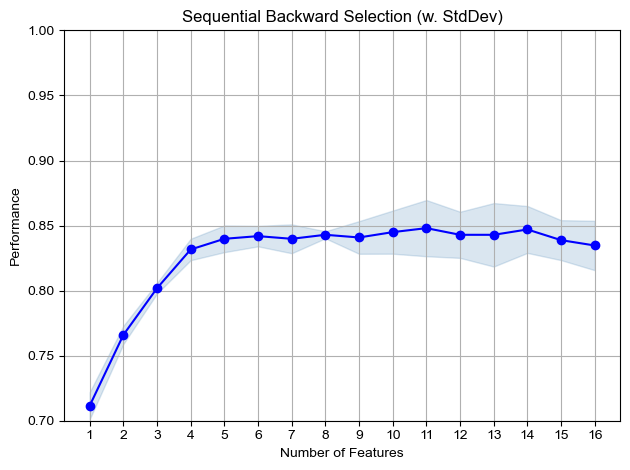

In [102]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [103]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


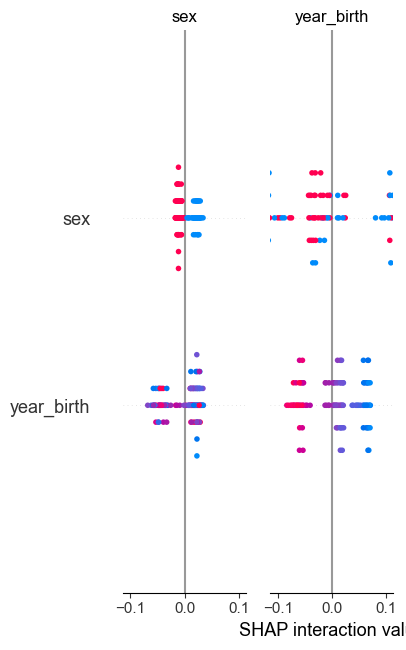

In [104]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

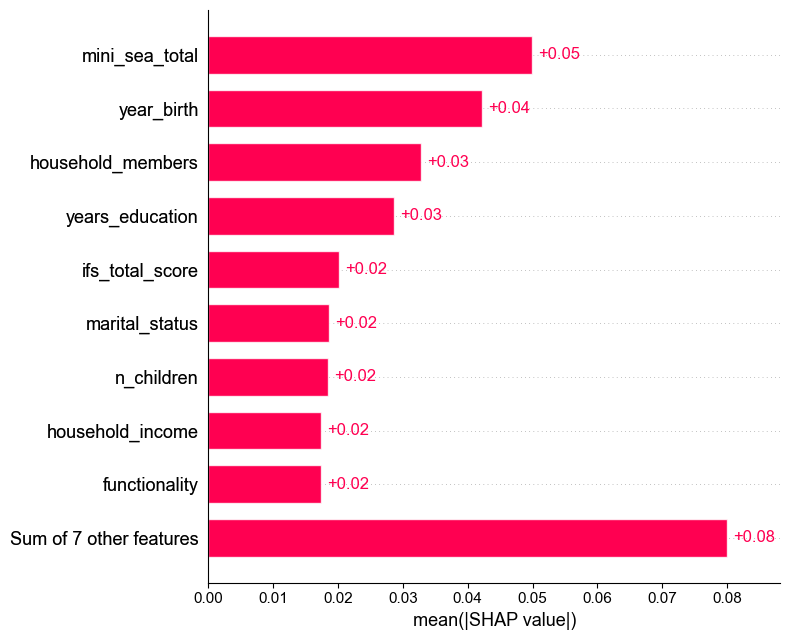

In [105]:
shap.plots.bar(shap_values[:,:,1])